![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Running Wflow using the ewatercycle system

This notebooks shows how to run [Wflow](https://wflow.readthedocs.io/en/latest/) model using an example use-case. More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) chapter in the eWaterCycle documentation.

In [1]:
import logging
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.WARN)

In [2]:
import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

## Setting up the model

The model needs a parameter set and forcing. The parameter set can be gotten from the available parameters sets on the system and the forcing can derived from the parameter set.

In [3]:
parameter_set = ewatercycle.parameter_sets.get_parameter_set("wflow_rhine_sbm_nc")
print(parameter_set)

Parameter set
-------------
name=wflow_rhine_sbm_nc
directory=/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc
config=/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini
doi=N/A
target_model=wflow
supported_model_versions={'2020.1.2', '2020.1.1'}


In [4]:
forcing = ewatercycle.forcing.load_foreign(
    directory=str(parameter_set.directory),
    target_model=parameter_set.target_model,
    start_time="1991-01-01T00:00:00Z",
    end_time="1991-12-31T00:00:00Z",
    forcing_info=dict(
        # Additional information about the external forcing data needed for the model configuration
        netcdfinput="inmaps.nc",
        Precipitation="/P",
        EvapoTranspiration="/PET",
        Temperature="/TEMP",
    ),
)
print(forcing)

Forcing data for Wflow
----------------------
Directory: /home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc
Start time: 1991-01-01T00:00:00Z
End time: 1991-12-31T00:00:00Z
Shapefile: None
Additional information for model config:
  - netcdfinput: inmaps.nc
  - Precipitation: /P
  - Temperature: /TEMP
  - EvapoTranspiration: /PET
  - Inflow: None


Pick a version of Wflow model, so the right model code can be executed which understands the parameter set and forcing.

In [5]:
ewatercycle.models.Wflow.available_versions

('2020.1.1', '2020.1.2')

In [6]:
model = ewatercycle.models.Wflow(
    version="2020.1.2", parameter_set=parameter_set, forcing=forcing
)

In [7]:
print(model)

eWaterCycle Wflow
-------------------
Version = 2020.1.2
Parameter set = 
  Parameter set
  -------------
  name=wflow_rhine_sbm_nc
  directory=/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc
  config=/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini
  doi=N/A
  target_model=wflow
  supported_model_versions={'2020.1.2', '2020.1.1'}
Forcing = 
  Forcing data for Wflow
  ----------------------
  Directory: /home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc
  Start time: 1991-01-01T00:00:00Z
  End time: 1991-12-31T00:00:00Z
  Shapefile: None
  Additional information for model config:
    - netcdfinput: inmaps.nc
    - Precipitation: /P
    - Temperature: /TEMP
    - EvapoTranspiration: /PET
    - Inflow: None


The pre-configured parameters are shown below and can be overwritten with `setup()`

In [8]:
model.parameters

[('start_time', '1991-01-01T00:00:00Z'), ('end_time', '1991-12-31T00:00:00Z')]

In [9]:
cfg_file, cfg_dir = model.setup(end_time="1991-02-28T00:00:00Z")

In [10]:
print(cfg_file)
print(cfg_dir)

/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/output/wflow_20211008_084304/wflow_ewatercycle.ini
/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/output/wflow_20211008_084304


The config file can be edited, but for now we will initialize the model with the config file as is

In [11]:
model.initialize(cfg_file)

## Running the model

In [12]:
while model.time < model.end_time:
    model.update()
    print(model.time_as_isostr)

1991-01-01T00:00:00Z
1991-01-02T00:00:00Z
1991-01-03T00:00:00Z
1991-01-04T00:00:00Z
1991-01-05T00:00:00Z
1991-01-06T00:00:00Z
1991-01-07T00:00:00Z
1991-01-08T00:00:00Z
1991-01-09T00:00:00Z
1991-01-10T00:00:00Z
1991-01-11T00:00:00Z
1991-01-12T00:00:00Z
1991-01-13T00:00:00Z
1991-01-14T00:00:00Z
1991-01-15T00:00:00Z
1991-01-16T00:00:00Z
1991-01-17T00:00:00Z
1991-01-18T00:00:00Z
1991-01-19T00:00:00Z
1991-01-20T00:00:00Z
1991-01-21T00:00:00Z
1991-01-22T00:00:00Z
1991-01-23T00:00:00Z
1991-01-24T00:00:00Z
1991-01-25T00:00:00Z
1991-01-26T00:00:00Z
1991-01-27T00:00:00Z
1991-01-28T00:00:00Z
1991-01-29T00:00:00Z
1991-01-30T00:00:00Z
1991-01-31T00:00:00Z
1991-02-01T00:00:00Z
1991-02-02T00:00:00Z
1991-02-03T00:00:00Z
1991-02-04T00:00:00Z
1991-02-05T00:00:00Z
1991-02-06T00:00:00Z
1991-02-07T00:00:00Z
1991-02-08T00:00:00Z
1991-02-09T00:00:00Z
1991-02-10T00:00:00Z
1991-02-11T00:00:00Z
1991-02-12T00:00:00Z
1991-02-13T00:00:00Z
1991-02-14T00:00:00Z
1991-02-15T00:00:00Z
1991-02-16T00:00:00Z
1991-02-17T00

## Inspect the results

The RiverRunnoff values of the current model state can be fetched as a [xarray dataset](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataset).

In [13]:
da = model.get_value_as_xarray("RiverRunoff")
da

<xarray.DataArray 'RiverRunoff' (latitude: 169, longitude: 187)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
    time       object 1991-02-28 00:00:00
Attributes:
    units:     m/s

In [14]:
print(da)

<xarray.DataArray 'RiverRunoff' (latitude: 169, longitude: 187)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
    time       object 1991-02-28 00:00:00
Attributes:
    units:     m/s


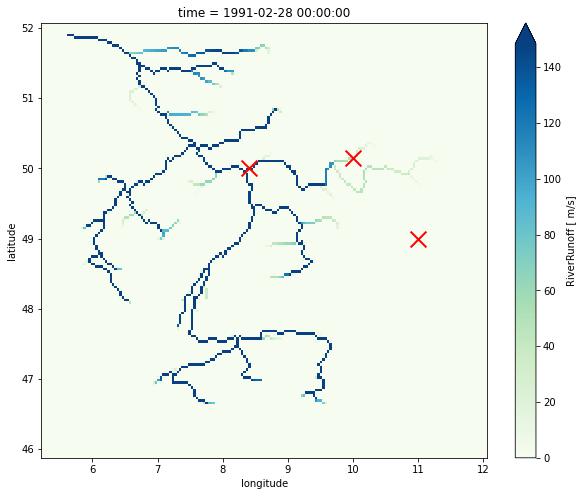

In [15]:
qm = da.plot(robust=True, cmap="GnBu", figsize=(10, 8))

# Add some verification points
target_longitudes = [8.4, 10, 11]
target_latitudes = [50, 50.15, 49]
# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter(target_longitudes, target_latitudes, s=250, c="r", marker="x", lw=2)

Instead of getting the whole spatial grid, you can also get RiverRunoff values at some coordinates (red crosses in above plot).

In [16]:
model.get_value_at_coords("RiverRunoff", lon=target_longitudes, lat=target_latitudes)

array([200.49531555,  44.60787582,   0.        ])

We are done with the model so let's clean it up.

In [17]:
model.finalize()